In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import operator
np.set_printoptions(suppress=True)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# from fastdtw import fastdtw
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
from tqdm import tqdm
import csv

from sklearn.manifold import MDS, LocallyLinearEmbedding, Isomap, TSNE

In [2]:
data = pd.read_csv('C:/Users/maria/OneDrive/Desktop/Smart_Meter_Data/New2.txt', sep=" ")

In [3]:
df = data[(data.id == 1539)]
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%y')
# df['month'] = pd.DatetimeIndex(df['date']).month
# df['week']= np.ceil((df['day']-200)/7).astype(int)
df.drop(df[df.day==452].index, inplace=True)
df

id  demand  day  period  dow  tow  week       date  month
8326656  1539   0.157  201       1    1    1     1 2009-07-20      7
8326657  1539   0.568  201       2    1    2     1 2009-07-20      7
8326658  1539   0.163  201       3    1    3     1 2009-07-20      7
8326659  1539   0.124  201       4    1    4     1 2009-07-20      7
8326660  1539   0.109  201       5    1    5     1 2009-07-20      7
...       ...     ...  ...     ...  ...  ...   ...        ...    ...
8351515  1539   0.133  725      44    7  332    75 2010-12-26     12
8351516  1539   0.198  725      45    7  333    75 2010-12-26     12
8351517  1539   0.192  725      46    7  334    75 2010-12-26     12
8351518  1539   0.144  725      47    7  335    75 2010-12-26     12
8351519  1539   0.187  725      48    7  336    75 2010-12-26     12

[24864 rows x 9 columns]

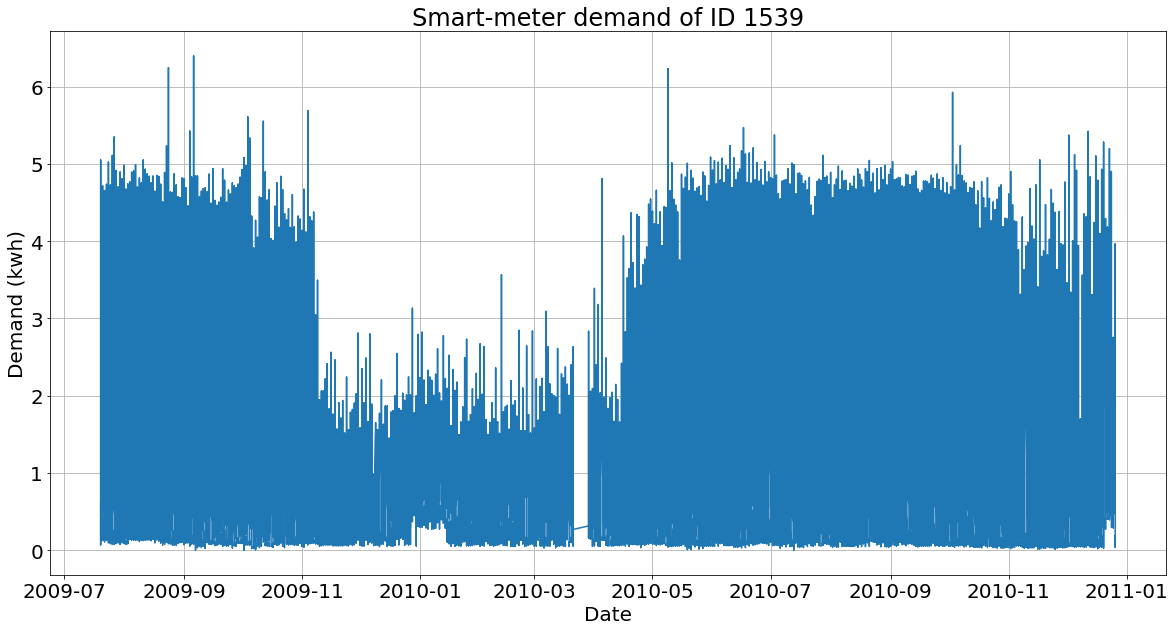

In [4]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 10))
plt.plot(df["date"], df["demand"])
plt.xlabel('Date')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of ID '+str(df.id.unique()[0]))
plt.grid()
plt.show()

# Observation as a daily distribution

In [5]:
df1 = df.groupby(['id','day','date','dow','month']).demand.apply(np.array).reset_index()
df1

id  day       date  dow  month  \
0    1539  201 2009-07-20    1      7   
1    1539  202 2009-07-21    2      7   
2    1539  203 2009-07-22    3      7   
3    1539  204 2009-07-23    4      7   
4    1539  205 2009-07-24    5      7   
..    ...  ...        ...  ...    ...   
513  1539  721 2010-12-22    3     12   
514  1539  722 2010-12-23    4     12   
515  1539  723 2010-12-24    5     12   
516  1539  724 2010-12-25    6     12   
517  1539  725 2010-12-26    7     12   

                                                demand  
0    [0.157, 0.568, 0.163, 0.124, 0.109, 0.139, 0.2...  
1    [0.382, 0.143, 0.445, 0.442, 0.142, 0.177, 0.1...  
2    [0.396, 0.306, 0.13, 0.131, 0.166, 0.162, 0.13...  
3    [0.208, 0.154, 0.145, 0.153, 0.379, 0.136, 0.1...  
4    [0.533, 0.158, 0.13, 0.151, 0.107, 0.162, 0.53...  
..                                                 ...  
513  [1.634, 0.631, 0.477, 0.541, 0.506, 0.521, 0.5...  
514  [0.571, 1.532, 1.804, 1.694, 1.663, 1.64, 1.42...  
515  [0.544, 0.529, 0.522, 0.539, 1.494, 0.842, 0.5...  
516  [0.457, 0.498, 1.214, 0.821, 0.419, 0.399, 0.3...  
517  [0.497, 0.532, 0.54, 0.511, 0.549, 0.532, 0.49...  

[518 rows x 6 columns]

In [6]:
dd_v1 = df1['demand'].to_numpy()
dd_arr1 = np.vstack(dd_v1)
print(dd_arr1.shape)
color_arr1 = df1['month'].to_numpy() # map to month
print(color_arr1.shape)
color_arr2 = df1['dow'].to_numpy() # map to day of week
print(color_arr2.shape)

(518, 48)
(518,)
(518,)


In [7]:
dd_v1[0]

array([0.157, 0.568, 0.163, 0.124, 0.109, 0.139, 0.275, 0.249, 0.24 ,
       0.212, 0.251, 0.27 , 0.705, 0.241, 0.239, 1.112, 3.014, 4.611,
       1.45 , 0.154, 0.112, 0.139, 0.886, 0.538, 1.028, 0.437, 0.135,
       0.11 , 0.135, 0.11 , 0.135, 0.068, 0.307, 0.134, 0.437, 0.132,
       0.132, 0.132, 0.109, 0.385, 2.682, 4.798, 5.049, 2.774, 1.744,
       0.152, 0.13 , 0.646])

In [8]:
dtw_matrix10 = dtw.distance_matrix_fast(dd_arr1)

In [9]:
dtw_matrix11 = dtw.distance_matrix_fast(dd_arr1,window=24)

In [10]:
dtw_matrix12 = dtw.distance_matrix_fast(dd_arr1,psi=2)
dtw_matrix13 = dtw.distance_matrix_fast(dd_arr1,psi=4)
dtw_matrix14 = dtw.distance_matrix_fast(dd_arr1,window=24,psi=2)
dtw_matrix15 = dtw.distance_matrix_fast(dd_arr1,window=24,psi=4)

## Colormap setting (color corresponding to seasons)

In [11]:
import matplotlib.colors
from matplotlib.colors import ListedColormap
def plotscatter(xdata,ydata,color_array,mapping_type="season"):
    '''Modified from reference https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar,
    answer by author Enzoupi. Colors map to seasons in Ireland:
    green-spring
    yellow-summer
    red-autumn
    blue-winter'''
    
    if mapping_type == "season":
        col_dict={1:"blue",
              2:"royalblue",
              3:"darkgreen",
              4:"forestgreen",
              5:"limegreen",
              6:"lemonchiffon",
              7:"khaki",
              8:"gold",          
              9:"orangered",          
              10:"red",
              11:"darkred",
              12:"darkblue"
             }
    elif mapping_type == "day":
        col_dict={1:"red",
              2:"orange",
              3:"yellow",
              4:"green",
              5:"blue",
              6:"indigo",
              7:"purple"
                }


    # We create a colormar from our list of colors
    cmap = ListedColormap([col_dict[x] for x in col_dict.keys()])
    labels = np.array(list(col_dict.keys()))
    len_lab = len(labels)
    # prepare normalizer
    ## Prepare bins for the normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    ## Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2

    plt.scatter(xdata,ydata,c = color_array, cmap=cmap, norm=norm)
    plt.colorbar(format=fmt, ticks=tickz)
    plt.axis('equal')
#     plt.show()

## MDS

### Using Euclidean distance

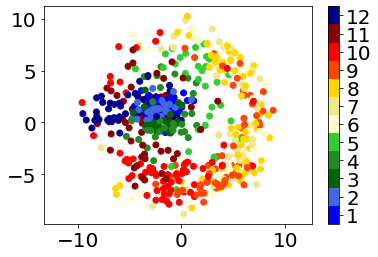

In [12]:
model_MDS = MDS(n_components=2, random_state=1)
out_MDS1 = model_MDS.fit_transform(dd_arr1)
plotscatter(out_MDS1[:, 0], out_MDS1[:, 1],color_arr1)

### Using Dynamic Time Warping (DTW)

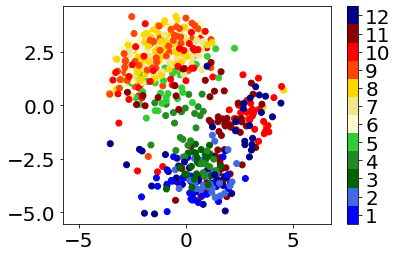

In [13]:
model_MDS = MDS(n_components=2,dissimilarity='precomputed', random_state=1)
out_MDS20 = model_MDS.fit_transform(dtw_matrix10)
out_MDS21 = model_MDS.fit_transform(dtw_matrix11)
out_MDS22 = model_MDS.fit_transform(dtw_matrix12)
out_MDS23 = model_MDS.fit_transform(dtw_matrix13)
out_MDS24 = model_MDS.fit_transform(dtw_matrix14)
out_MDS25 = model_MDS.fit_transform(dtw_matrix15)
plotscatter(out_MDS20[:, 0], out_MDS20[:, 1],color_arr1)

### Comparison

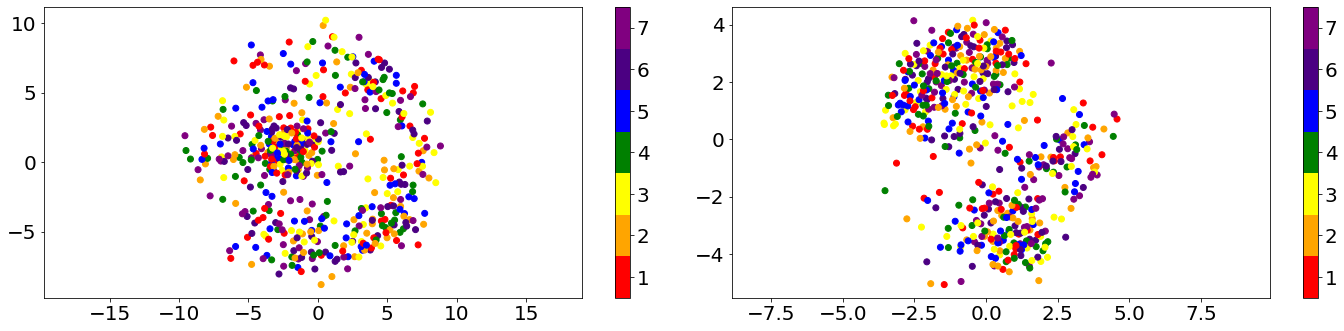

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plotscatter(out_MDS1[:, 0], out_MDS1[:, 1],color_arr2,mapping_type="day")

plt.subplot(1, 2, 2)
plotscatter(out_MDS20[:, 0], out_MDS20[:, 1],color_arr2,mapping_type="day")


plt.tight_layout()

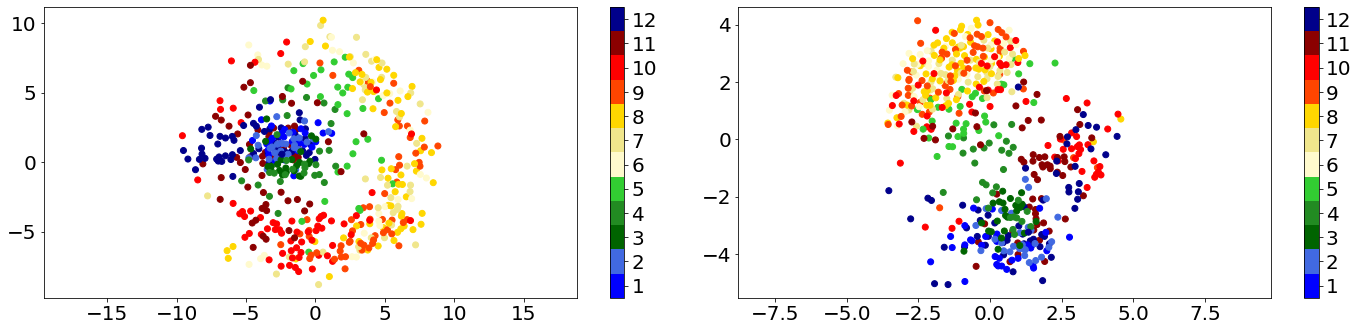

In [15]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plotscatter(out_MDS1[:, 0], out_MDS1[:, 1],color_arr1)

plt.subplot(1, 2, 2)
plotscatter(out_MDS20[:, 0], out_MDS20[:, 1],color_arr1)


plt.tight_layout()

## Isomap

### Using Euclidean distance

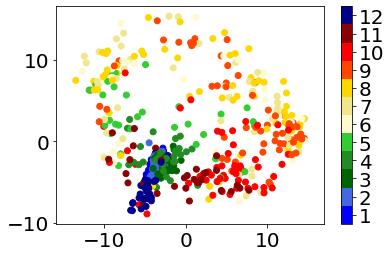

In [40]:
model_Isomap = Isomap(n_neighbors=20, n_components=2, eigen_solver='dense')
out_Isomap1 = model_Isomap.fit_transform(dd_arr1)

plotscatter(out_Isomap1[:, 0], out_Isomap1[:, 1], color_arr1)

### Using Dynamic Time Warping (DTW)

In [17]:
# model_Isomap = Isomap(n_neighbors=5, n_components=2,metric='percomputed')
# out_Isomap2 = model_Isomap.fit_transform(dtw_matrix1)

# plt.scatter(out_Isomap2[:, 0], out_Isomap2[:, 1], c=color_arr1,  cmap=cmap, norm=norm)
# plt.colorbar(ticks=tickz)
# plt.axis('equal')

In [18]:
def distance_mat(X, window=None, psi=None, n_neighbors=6):
    """
    Compute the square distance matrix using DTW
    :param X: Input data, a numpy array of shape (img_height, img_width)
    :param n_neighbors: Number of nearest neighbors to consider, int
    :return: numpy array of shape (img_height, img_height), numpy array of shape (img_height, n_neighbors)
    """

    # Compute full distance matrix
    distances = dtw.distance_matrix_fast(X, window=window,psi=psi)

    # Keep only the 6 nearest neighbors, others set to 0 (= unreachable)
    neighbors = np.zeros_like(distances)
    sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
    for k,i in enumerate(sort_distances):
        neighbors[k,i] = distances[k,i]
    return neighbors, sort_distances

In [19]:
def center(K):
    """
    Method to center the distance matrix
    :param K: numpy array of shape mxm
    :return: numpy array of shape mxm
    """
    n_samples = K.shape[0]

    # Mean for each row/column
    meanrows = np.sum(K, axis=0) / n_samples
    meancols = (np.sum(K, axis=1)/n_samples)[:, np.newaxis]

    # Mean across all rows (entire matrix)
    meanall = meanrows.sum() / n_samples

    K -= meanrows
    K -= meancols
    K += meanall
    return K

In [20]:
def mds(data, n_components=2):
    """
    Apply multidimensional scaling (aka Principal Coordinates Analysis)
    :param data: nxn square distance matrix
    :param n_components: number of components for projection
    :return: projected output of shape (n_components, n)
    """

    # Center distance matrix
    center(data)
    
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_val_cov, eig_vec_cov = np.linalg.eig(data)
    eig_pairs = [
        (np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))
    ]
    
    # Select n_components eigenvectors with largest eigenvalues, obtain subspace transform matrix
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    eig_pairs = np.array(eig_pairs)
    matrix_w = np.hstack(
        [eig_pairs[i, 1].reshape(data.shape[1], 1) for i in range(n_components)]
    )

    # Return samples in new subspace
    return matrix_w

In [21]:
def isomap(data,window=None,psi=None,n_components=2, n_neighbors=6):
    """
    Dimensionality reduction with isomap algorithm
    :param data: input image matrix of shape (n,m) if dist=False, square distance matrix of size (n,n) if dist=True
    :param n_components: number of components for projection
    :param n_neighbors: number of neighbors for distance matrix computation
    :return: Projected output of shape (n_components, n)
    """
    # Compute distance matrix
    data, _ = distance_mat(data, window,psi, n_neighbors)

    # Compute shortest paths from distance matrix
    from sklearn.utils.graph import graph_shortest_path
    graph = graph_shortest_path(data, directed=False)
    graph = -0.5 * (graph ** 2)

    # Return the MDS projection on the shortest paths graph
    return mds(graph, n_components)

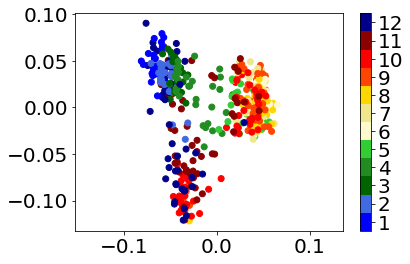

In [39]:
from dtaidistance import dtw
scratch_Isomap20 = isomap(dd_arr1,n_neighbors=20)
# scratch_Isomap21 = isomap(dd_arr1,window= 24,n_neighbors=20)
# scratch_Isomap22 = isomap(dd_arr1,psi= 2,n_neighbors=20)
# scratch_Isomap23 = isomap(dd_arr1,psi= 4,n_neighbors=20)
# scratch_Isomap24 = isomap(dd_arr1,window= 24,psi= 2,n_neighbors=20)
# scratch_Isomap25 = isomap(dd_arr1,window= 24,psi= 4,n_neighbors=20)
plotscatter(scratch_Isomap20[:, 0], scratch_Isomap20[:, 1],color_arr1)

### Comparison

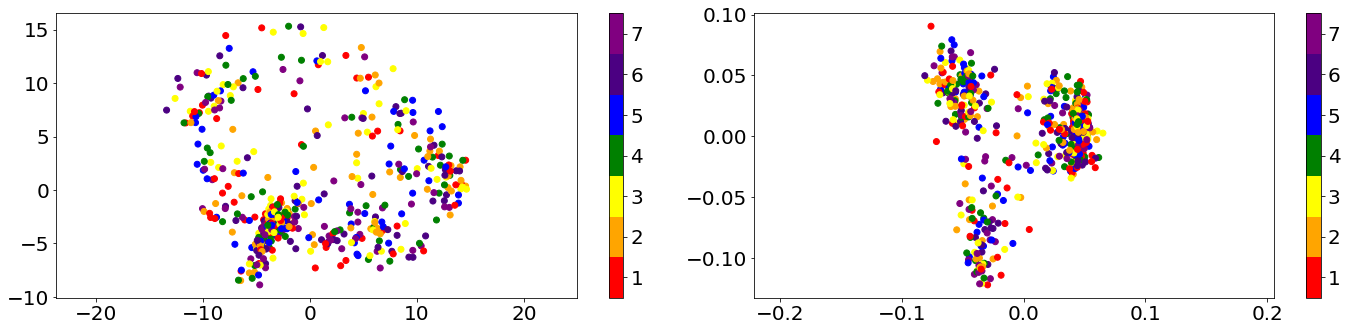

In [23]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plotscatter(out_Isomap1[:, 0], out_Isomap1[:, 1], color_arr2,mapping_type="day")

plt.subplot(1, 2, 2)
plotscatter(scratch_Isomap20[:, 0], scratch_Isomap20[:, 1],color_arr2,mapping_type="day")

plt.tight_layout()

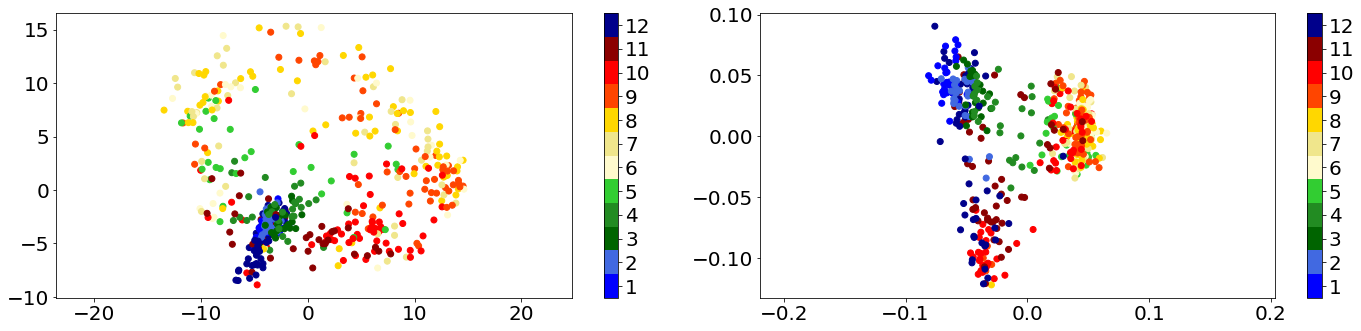

In [41]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plotscatter(out_Isomap1[:, 0], out_Isomap1[:, 1], color_arr1)

plt.subplot(1, 2, 2)
plotscatter(scratch_Isomap20[:, 0], scratch_Isomap20[:, 1],color_arr1)

plt.tight_layout()

In [25]:
col_dict={1:"blue",
              2:"royalblue",
              3:"darkgreen",
              4:"forestgreen",
              5:"limegreen",
              6:"lemonchiffon",
              7:"khaki",
              8:"gold",          
              9:"orangered",          
              10:"red",
              11:"darkred",
              12:"darkblue"
             }
# We create a colormar from our list of colors
cmap = ListedColormap([col_dict[x] for x in col_dict.keys()])
labels = np.array(list(col_dict.keys()))
len_lab = len(labels)
# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2

# plt.scatter(xdata,ydata,c = color_array, cmap=cmap, norm=norm)
# plt.colorbar(format=fmt, ticks=tickz)
# plt.axis('equal')

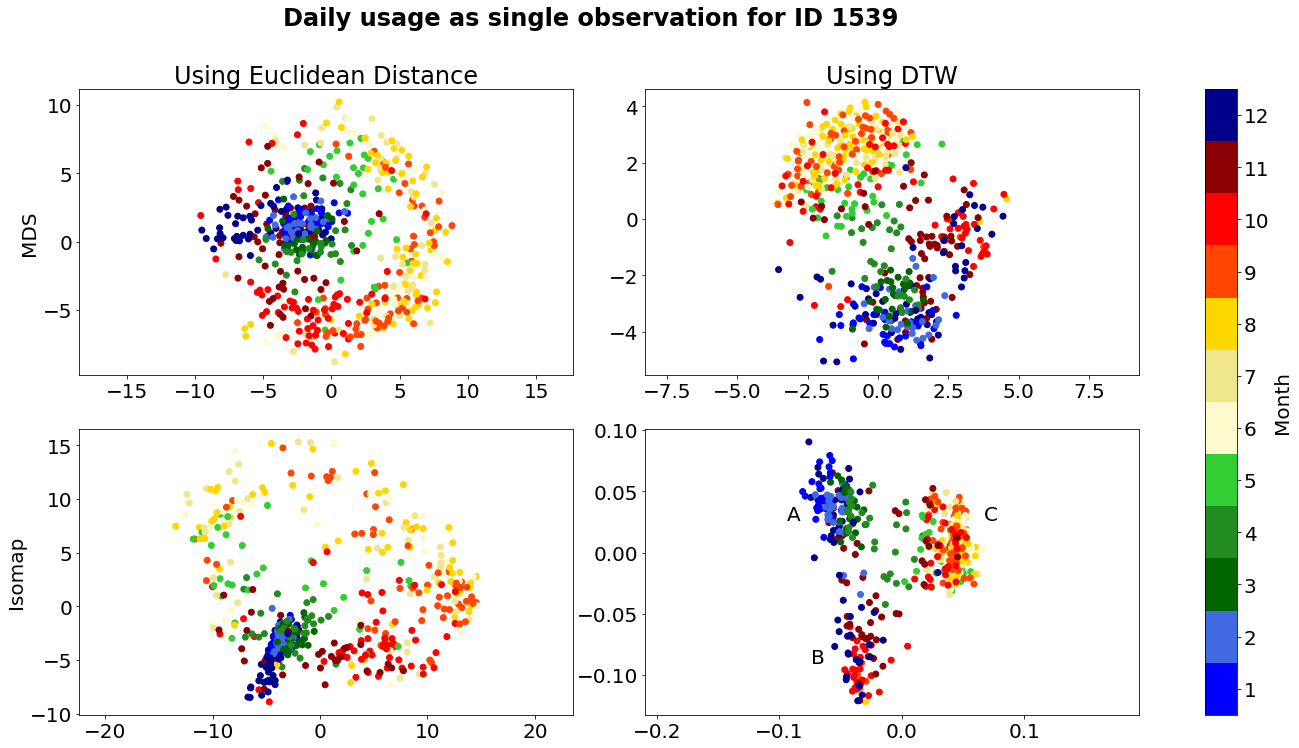

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
((ax1, ax2),(ax3, ax4))=axs

ax1.scatter(out_MDS1[:, 0], out_MDS1[:, 1],c = color_arr1, cmap=cmap, norm=norm)
ax1.axis('equal')
ax1.set_title("Using Euclidean Distance")
ax1.set_ylabel("MDS")

ax2.scatter(out_MDS20[:, 0], out_MDS20[:, 1],c = color_arr1, cmap=cmap, norm=norm)
ax2.axis('equal')
ax2.set_title("Using DTW")

ax3.scatter(out_Isomap1[:, 0], out_Isomap1[:, 1],c = color_arr1, cmap=cmap, norm=norm)
ax3.axis('equal')
ax3.set_ylabel("Isomap")

im = ax4.scatter(scratch_Isomap20[:, 0], scratch_Isomap20[:, 1],c = color_arr1, cmap=cmap, norm=norm)
ax4.axis('equal')

plt.tight_layout()

ax4.text(0.3, 0.7, 'A', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)
ax4.text(0.35, 0.2, 'B', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)
ax4.text(0.7, 0.7, 'C', horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)

fig.colorbar(im,ax=axs,label='Month',format=fmt, ticks=tickz)
fig.suptitle("Daily usage as single observation for ID 1539",x=0.42,y=1.05,fontweight="bold")

plt.axis('equal')

plt.show()
fig.savefig('1539daily.png',bbox_inches='tight')

## Use plotly to locate interested observations

In [27]:
def array_to_pd(my_array):
    '''Convert numpy.ndarray into pandas dataframe
    input: (N,2)array
    output: df '''
    df = pd.DataFrame(my_array, columns = ['x','y'])
    return df

In [28]:
import plotly.express as px
df_iso1 = array_to_pd(out_Isomap1)
fig = px.scatter(df_iso1,x="x", y="y",hover_data= [df_iso1.index], color=list(map(str, color_arr1)),
                color_discrete_map={
                "1":"blue",
                "2":"royalblue",
                "3":"darkgreen",
                "4":"forestgreen",
                "5":"limegreen",
                "6":"lemonchiffon",
                "7":"khaki",
                "8":"gold",          
                "9":"orangered",          
                "10":"red",
                "11":"darkred",
                '12':"darkblue"},
                 category_orders={"Month": ["11", "10", "9", "8", "7", "6","5","4","3","2","1","12"]})
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

In [29]:
df_iso20 = array_to_pd(scratch_Isomap20)
fig = px.scatter(df_iso20,x="x", y="y",hover_data= [df_iso20.index], color=list(map(str, color_arr1)),
                color_discrete_map={
                "1":"blue",
                "2":"royalblue",
                "3":"darkgreen",
                "4":"forestgreen",
                "5":"limegreen",
                "6":"lemonchiffon",
                "7":"khaki",
                "8":"gold",          
                "9":"orangered",          
                "10":"red",
                "11":"darkred",
                '12':"darkblue"},
                 category_orders={"Month": ["11", "10", "9", "8", "7", "6","5","4","3","2","1","12"]})
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

In [28]:
scratch_Isomap20[513]

array([-0.03443756, -0.08921231])

In [29]:
df1[df1.index==513]

id  day       date  dow  month  \
513  1539  709 2010-12-10    5     10   

                                                demand  
513  [0.403, 0.145, 0.131, 0.106, 0.147, 0.129, 0.1...

In [30]:
dd_arr1[513]

array([0.403, 0.145, 0.131, 0.106, 0.147, 0.129, 0.107, 0.147, 0.119,
       0.118, 0.15 , 0.107, 0.126, 0.144, 0.102, 0.129, 0.144, 0.11 ,
       0.123, 0.144, 0.307, 0.058, 0.183, 0.041, 0.821, 0.067, 0.037,
       0.366, 0.07 , 0.167, 1.618, 3.224, 4.353, 2.159, 0.425, 0.141,
       0.183, 0.174, 0.109, 0.092, 0.073, 0.048, 0.088, 0.062, 0.052,
       0.088, 0.053, 0.066])

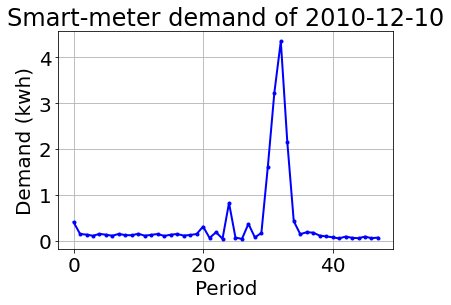

In [141]:
plt.plot(dd_arr1[513], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('Period')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df1.date.dt.date[513]))
plt.grid()
plt.show()

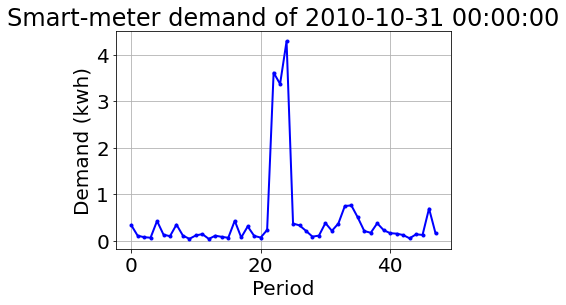

In [58]:
plt.plot(dd_arr1[473], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('Period')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df1.date[473]))
plt.grid()
plt.show()

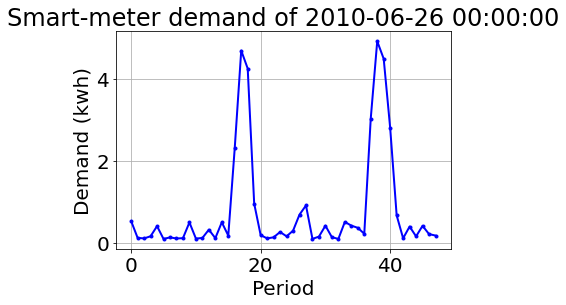

In [59]:
plt.plot(dd_arr1[346], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('Period')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df1.date[346]))
plt.grid()
plt.show()

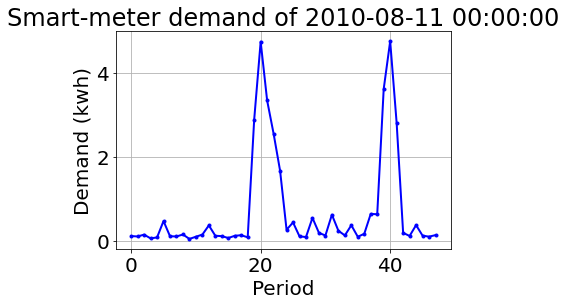

In [60]:
plt.plot(dd_arr1[392], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('Period')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df1.date[392]))
plt.grid()
plt.show()

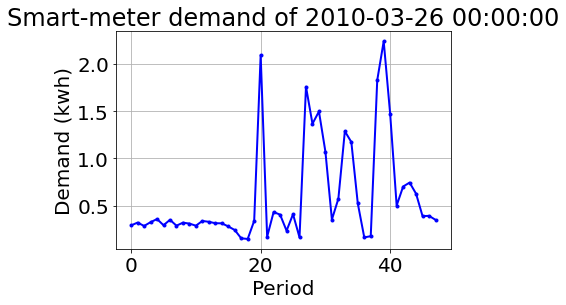

In [61]:
plt.plot(dd_arr1[255], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('Period')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df1.date[255]))
plt.grid()
plt.show()

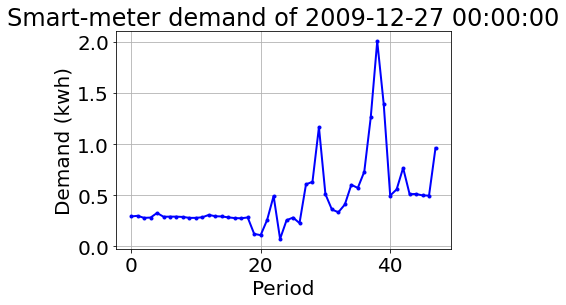

In [62]:
plt.plot(dd_arr1[166], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('Period')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df1.date[166]))
plt.grid()
plt.show()

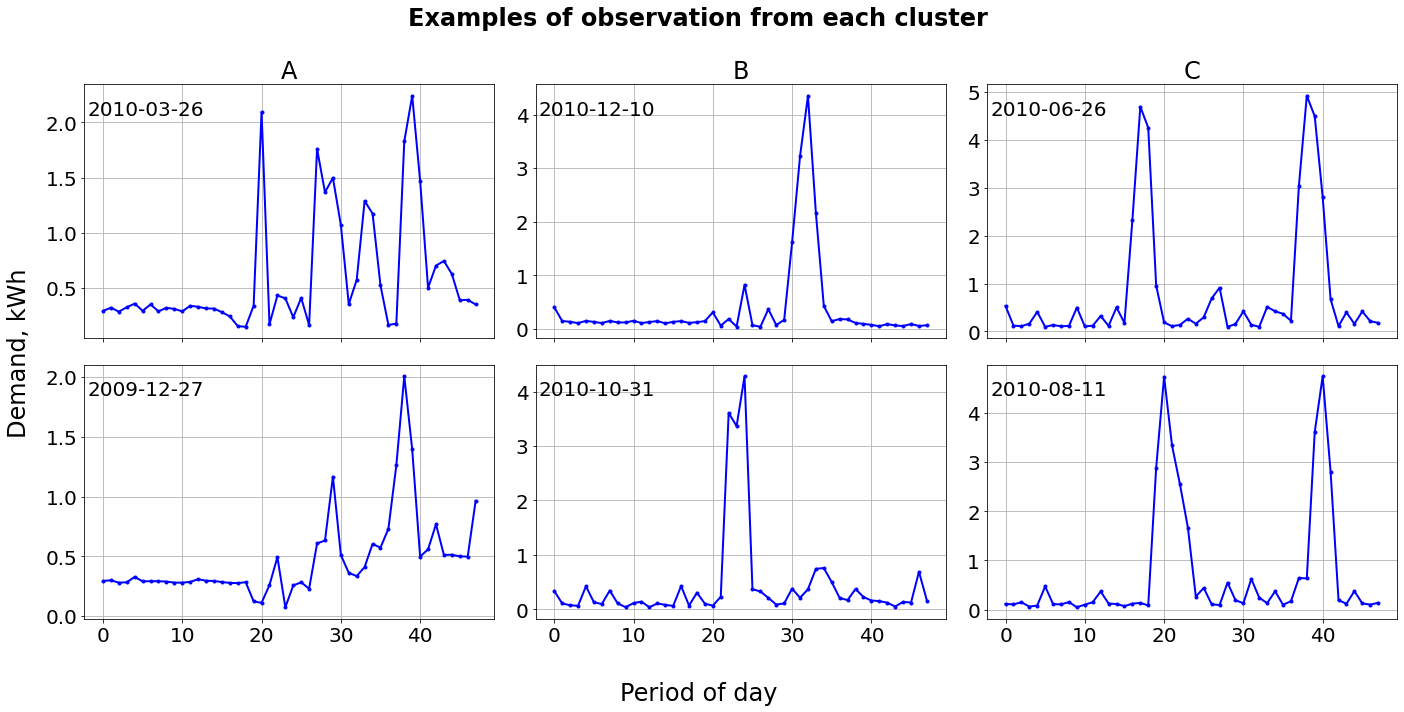

In [160]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True,figsize=(20, 10))
((ax1, ax2,ax3),(ax4, ax5,ax6))=axs

ax1.plot(dd_arr1[255], color='blue', marker='o', markersize=3, linewidth=2)
ax1.set_title("A")
ax1.grid()

ax2.plot(dd_arr1[513], color='blue', marker='o', markersize=3, linewidth=2)
ax2.set_title("B")
ax2.grid()

ax3.plot(dd_arr1[346], color='blue', marker='o', markersize=3, linewidth=2)
ax3.set_title("C")
ax3.grid()

ax4.plot(dd_arr1[166], color='blue', marker='o', markersize=3, linewidth=2)
ax4.grid()

ax5.plot(dd_arr1[473], color='blue', marker='o', markersize=3, linewidth=2)
ax5.grid()

im = ax6.plot(dd_arr1[392], color='blue', marker='o', markersize=3, linewidth=2)
ax6.grid()

dates = [str(df1.date.dt.date[x]) for x in [255, 513, 346, 166, 473, 392]]
axes =[ax1, ax2,ax3,ax4, ax5,ax6]
for ax, date in zip(axes, dates):
    ax.text(0.15, 0.9, date, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

fig.suptitle("Examples of observation from each cluster",fontweight="bold")
fig.supxlabel('Period of day')
fig.supylabel('Demand, kWh')

# fig.text(0.5, 0.01, 'Period of day', ha='center')
# fig.text(0.003, 0.5, 'Demand, kWh', va='center', rotation='vertical')
# plt.xlabel("Period")
# plt.ylabel("Demand, (kwh)")
plt.tight_layout()
plt.show()
fig.savefig('cluster_eg.png')

In [150]:
[str(df1.date.dt.date[x]) for x in [255, 513, 346, 166, 473, 392]]

['2010-03-26',
 '2010-12-10',
 '2010-06-26',
 '2009-12-27',
 '2010-10-31',
 '2010-08-11']

# Observation as a time of week (tow)

In [37]:
# df = data[(data.id == 1049)&(data.day>200)&(data.day<726)] 
df.drop(df[df.week==0].index, inplace=True) # first week started on day 201
df.drop(df[df.week==36].index, inplace=True)# for now delete the week which contains day 452
df.drop(df[df.week==76].index, inplace=True) # last week is week 75
df2 = df.groupby(['dow','period','tow']).demand.apply(np.array).reset_index()
df2

dow  period  tow                                             demand
0      1       1    1  [0.157, 0.252, 0.131, 0.14, 0.15, 0.319, 0.767...
1      1       2    2  [0.568, 0.148, 0.518, 0.145, 0.151, 0.684, 0.1...
2      1       3    3  [0.163, 0.447, 0.127, 0.146, 0.527, 0.253, 0.1...
3      1       4    4  [0.124, 0.095, 0.111, 0.391, 0.139, 0.147, 0.1...
4      1       5    5  [0.109, 0.144, 0.12, 0.159, 0.145, 0.142, 0.19...
..   ...     ...  ...                                                ...
331    7      44  332  [2.508, 0.559, 0.68, 0.207, 0.73, 0.756, 0.418...
332    7      45  333  [0.289, 0.384, 0.193, 0.79, 0.111, 0.144, 0.21...
333    7      46  334  [1.082, 0.15, 0.214, 0.305, 0.148, 0.195, 0.18...
334    7      47  335  [0.495, 0.115, 0.53, 0.166, 0.147, 0.537, 0.44...
335    7      48  336  [0.217, 0.106, 0.462, 0.149, 0.148, 0.638, 0.1...

[336 rows x 4 columns]

In [38]:
dd_v2 = df2['demand'].to_numpy()
dd_arr2 = np.vstack(dd_v2)
print(dd_arr2.shape)
color_arr3 = df2['period'].to_numpy() # map to period
print(color_arr3.shape)

(336, 74)
(336,)


In [39]:
dtw_matrix20 = dtw.distance_matrix_fast(dd_arr2)
dtw_matrix21 = dtw.distance_matrix_fast(dd_arr2,window=24)
dtw_matrix22 = dtw.distance_matrix_fast(dd_arr2,psi=2)
dtw_matrix23 = dtw.distance_matrix_fast(dd_arr2,psi=4)
dtw_matrix24 = dtw.distance_matrix_fast(dd_arr2,window=24,psi=2)
dtw_matrix25 = dtw.distance_matrix_fast(dd_arr2,window=24,psi=4)

## MDS

### Using Euclidean distance

(-14.276746398943958,
 18.449268072324983,
 -20.52135838226337,
 12.173810718697897)

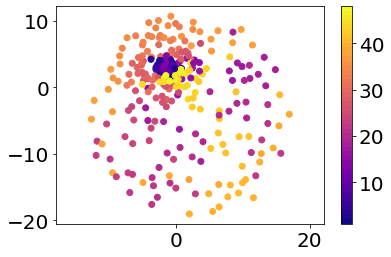

In [40]:
model_MDS = MDS(n_components=2, random_state=1)
out_MDS3 = model_MDS.fit_transform(dd_arr2)
plt.scatter(out_MDS3[:, 0], out_MDS3[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

### Using Dynamic Time Warping (DTW)

(-6.487790467905976, 12.35448167311997, -7.677567104756231, 11.587659085435192)

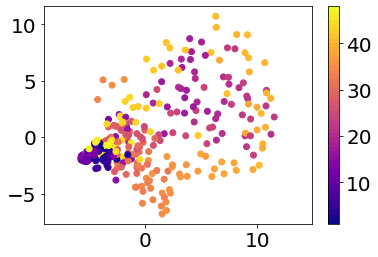

In [41]:
model_MDS = MDS(n_components=2,dissimilarity='precomputed', random_state=1)
out_MDS40 = model_MDS.fit_transform(dtw_matrix20)
out_MDS41 = model_MDS.fit_transform(dtw_matrix21)
out_MDS42 = model_MDS.fit_transform(dtw_matrix22)
out_MDS43 = model_MDS.fit_transform(dtw_matrix23)
out_MDS44 = model_MDS.fit_transform(dtw_matrix24)
out_MDS45 = model_MDS.fit_transform(dtw_matrix25)
plt.scatter(out_MDS40[:, 0], out_MDS40[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

### Comparison

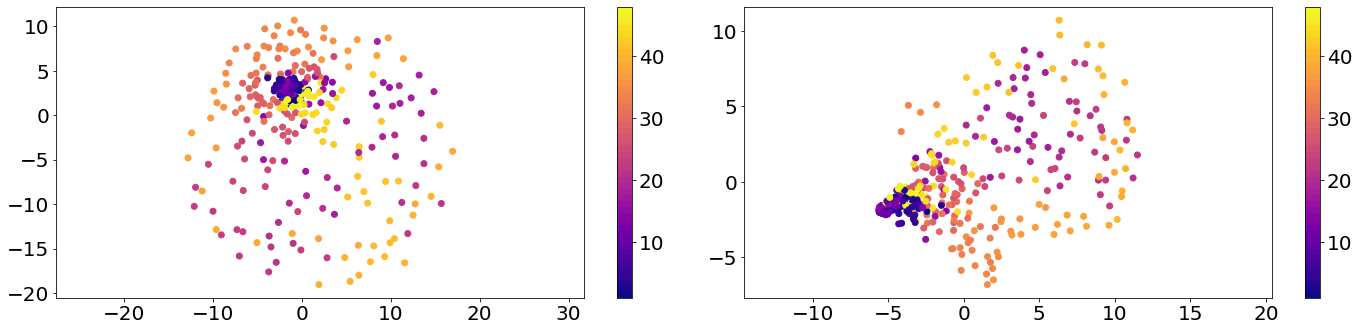

In [42]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.scatter(out_MDS3[:, 0], out_MDS3[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(out_MDS40[:, 0], out_MDS40[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

plt.tight_layout()

## Isomap

### Using Euclidean distance

(-14.736992359393799,
 35.680210950276205,
 -18.999663999080525,
 20.54578566528081)

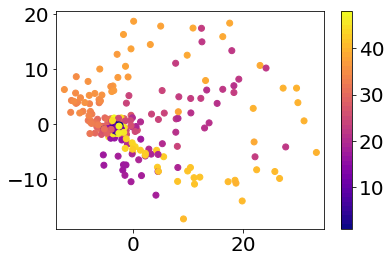

In [43]:
model_Isomap = Isomap(n_neighbors=20, n_components=2, eigen_solver='dense')
out_Isomap3 = model_Isomap.fit_transform(dd_arr2)

plt.scatter(out_Isomap3[:, 0], out_Isomap3[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')
# plt.clim('-0.5, 9.5')

### Using Dynamic Time Warping (DTW)

In [44]:
# model_Isomap = Isomap(n_neighbors=5, n_components=2,metric='percomputed')
# out_Isomap4 = model_Isomap.fit_transform(dtw_matrix2)

# plt.scatter(out_Isomap4[:, 0], out_Isomap4[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
# plt.colorbar()
# plt.axis('equal')

(-0.14725980446813067,
 0.06523684422528192,
 -0.15674336061570632,
 0.17581554821627857)

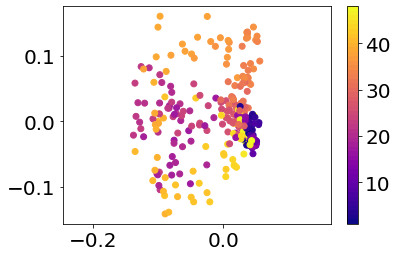

In [45]:
scratch_Isomap40 = isomap(dd_arr2,n_neighbors=20)
scratch_Isomap41 = isomap(dd_arr2,window=24,n_neighbors=20)
scratch_Isomap42 = isomap(dd_arr2,psi=2, n_neighbors=20)
scratch_Isomap43 = isomap(dd_arr2,psi=4, n_neighbors=20)
scratch_Isomap44 = isomap(dd_arr2,window=24,psi=2,n_neighbors=20)
scratch_Isomap45 = isomap(dd_arr2,window=24,psi=4,n_neighbors=20)
plt.scatter(scratch_Isomap40[:, 0], scratch_Isomap40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

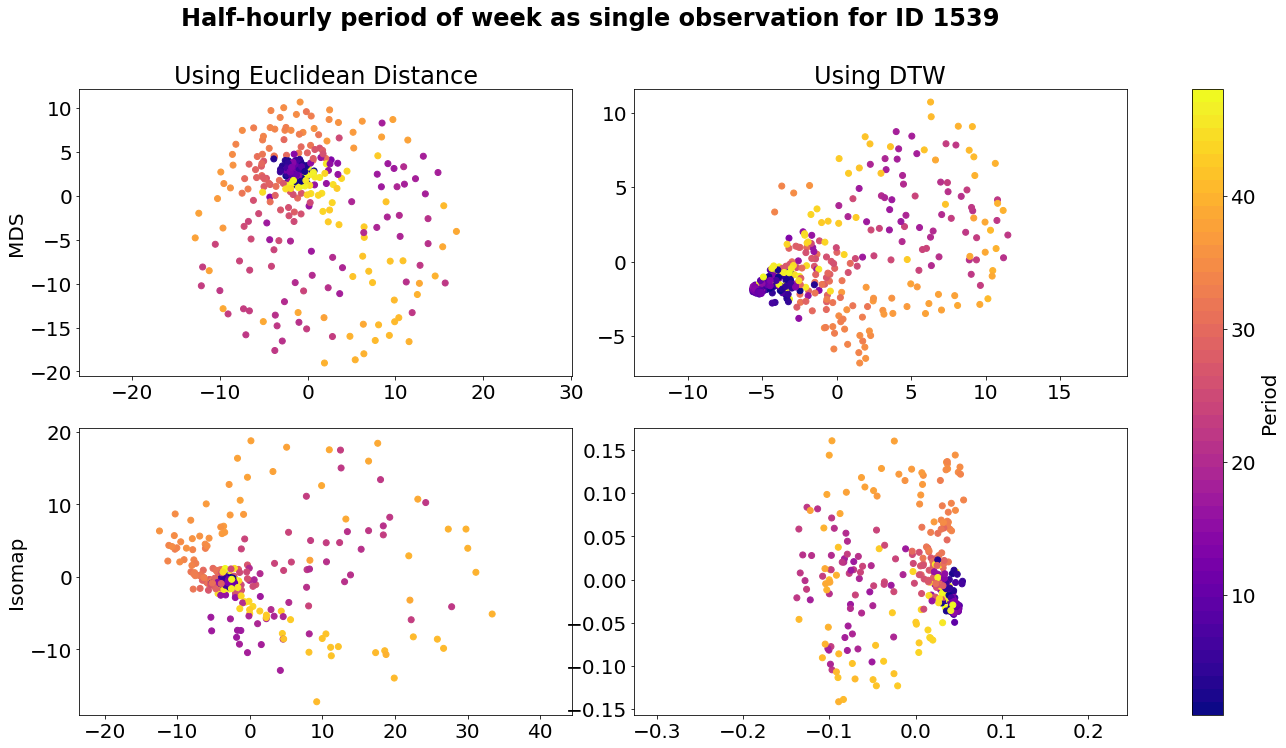

In [163]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
((ax1, ax2),(ax3, ax4))=axs

ax1.scatter(out_MDS3[:, 0], out_MDS3[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax1.axis('equal')
ax1.set_title("Using Euclidean Distance")
ax1.set_ylabel("MDS")

ax2.scatter(out_MDS40[:, 0], out_MDS40[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax2.axis('equal')
ax2.set_title("Using DTW")

ax3.scatter(out_Isomap3[:, 0], out_Isomap3[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax3.axis('equal')
ax3.set_ylabel("Isomap")

im = ax4.scatter(scratch_Isomap40[:, 0], scratch_Isomap40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax4.axis('equal')

plt.tight_layout()

fig.colorbar(im,ax=axs,label='Period')
fig.suptitle("Half-hourly period of week as single observation for ID 1539",x=0.42,y=1.05,fontweight="bold")
fig.savefig('1539period.png',bbox_inches='tight')
plt.axis('equal')

plt.show()


### Comparison

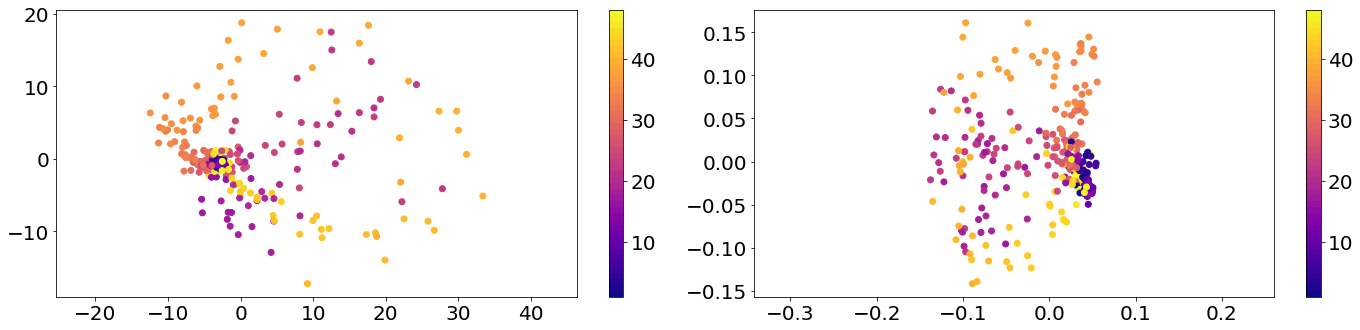

In [46]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.scatter(out_Isomap3[:, 0], out_Isomap3[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(scratch_Isomap40[:, 0], scratch_Isomap40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

plt.tight_layout()

In [47]:
df_iso40 = array_to_pd(scratch_Isomap40)
fig = px.scatter(df_iso40, x="x", y="y",hover_data=[df_iso40.index],color=color_arr3,
                )
fig.show()

In [48]:
df2[df2.index==41]

dow  period  tow                                             demand
41    1      42   42  [4.798, 4.394, 0.647, 2.665, 2.41, 0.481, 3.48...

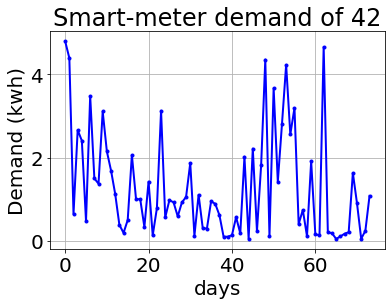

In [118]:
plt.plot(dd_arr2[41], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('days')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df2.tow[41]))
plt.grid()
plt.show()

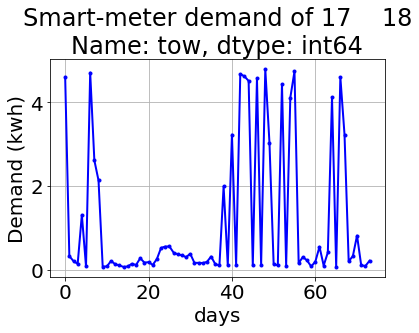

In [50]:
plt.plot(dd_arr2[17], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('days')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df2[df2.index==17].tow))
plt.grid()
plt.show()

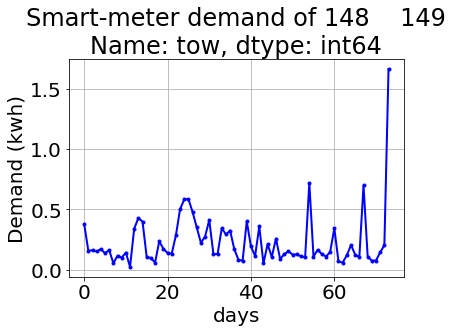

In [51]:
plt.plot(dd_arr2[148], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('days')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df2[df2.index==148].tow))
plt.grid()
plt.show()

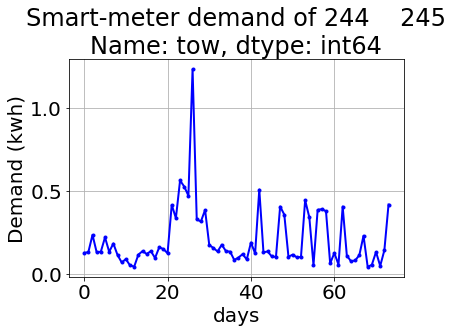

In [52]:
plt.plot(dd_arr2[244], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('days')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df2[df2.index==244].tow))
plt.grid()
plt.show()

## Sensitivity analysis for DTW

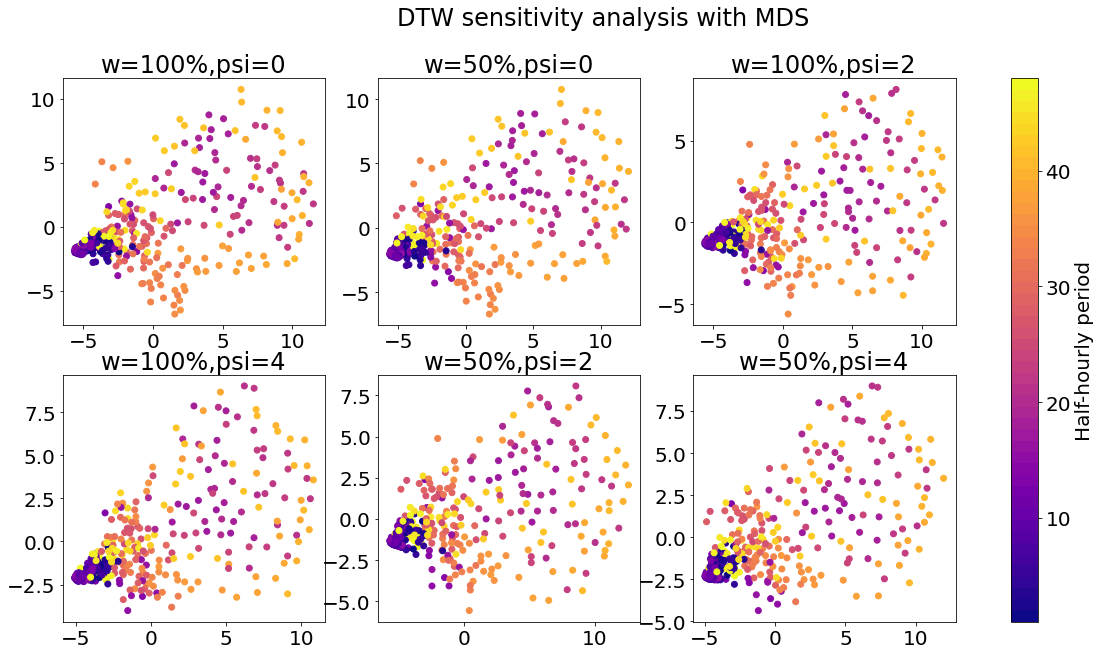

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
((ax1, ax2,ax3),(ax4,ax5,ax6))=axs
ax1.scatter(out_MDS40[:, 0], out_MDS40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax1.set_title("w=100%,psi=0")

ax2.scatter(out_MDS41[:, 0], out_MDS41[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax2.set_title("w=50%,psi=0")

ax3.scatter(out_MDS42[:, 0], out_MDS42[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax3.set_title("w=100%,psi=2")

ax4.scatter(out_MDS43[:, 0], out_MDS43[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax4.set_title("w=100%,psi=4")

ax5.scatter(out_MDS44[:, 0], out_MDS44[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax5.set_title("w=50%,psi=2")

im = ax6.scatter(out_MDS45[:, 0], out_MDS45[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax6.set_title("w=50%,psi=4")

fig.colorbar(im,ax=axs,label='Half-hourly period')
fig.suptitle("DTW sensitivity analysis with MDS")

plt.show()

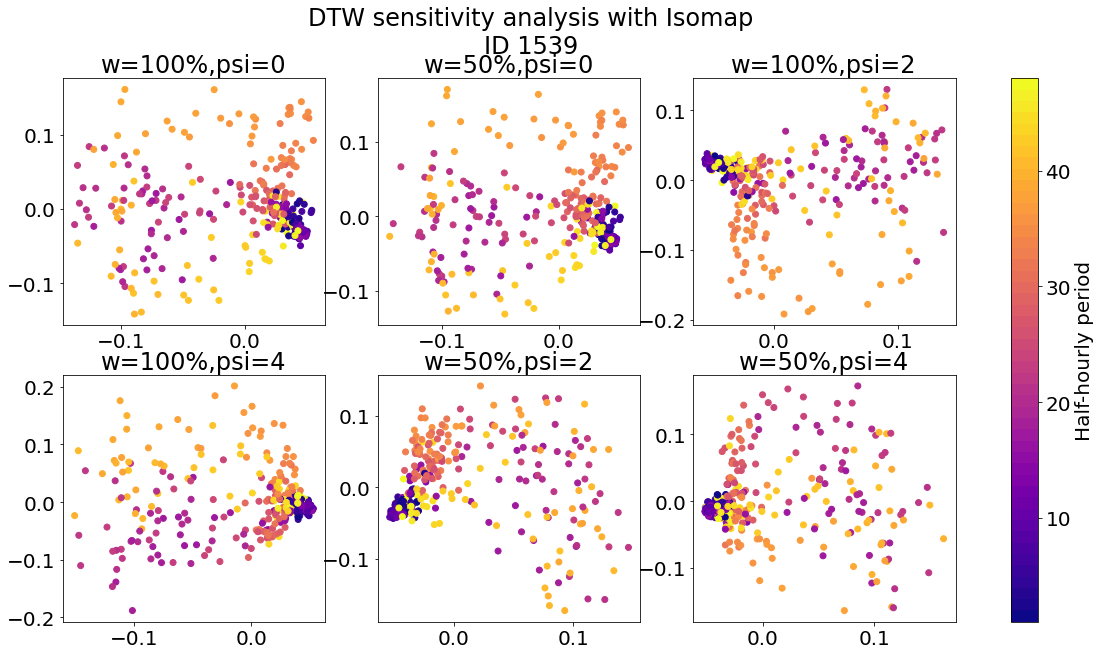

In [88]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
((ax1, ax2,ax3),(ax4,ax5,ax6))=axs
ax1.scatter(scratch_Isomap40[:, 0], scratch_Isomap40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax1.set_title("w=100%,psi=0")

ax2.scatter(scratch_Isomap41[:, 0], scratch_Isomap41[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax2.set_title("w=50%,psi=0")

ax3.scatter(scratch_Isomap42[:, 0], scratch_Isomap42[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax3.set_title("w=100%,psi=2")

ax4.scatter(scratch_Isomap43[:, 0], scratch_Isomap43[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax4.set_title("w=100%,psi=4")

ax5.scatter(scratch_Isomap44[:, 0], scratch_Isomap44[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax5.set_title("w=50%,psi=2")

im = ax6.scatter(scratch_Isomap45[:, 0], scratch_Isomap45[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax6.set_title("w=50%,psi=4")

fig.colorbar(im,ax=axs,label='Half-hourly period')
fig.suptitle("DTW sensitivity analysis with Isomap\nID 1539",x=0.45)

plt.show()

In [55]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=("w=100%,psi=0", "w=50%,psi=0", "w=100%,psi=2", "w=100%,psi=4","w=50%,psi=2","w=50%,psi=4"))

seq_color1 = list(map(str, color_arr1))
map_color ={"1":"blue",
            "2":"royalblue",
            "3":"darkgreen",
            "4":"forestgreen",
            "5":"limegreen",
            "6":"lemonchiffon",
            "7":"khaki",
            "8":"gold",          
            "9":"orangered",          
            "10":"red",
            "11":"darkred",
            '12':"darkblue"}

fig.add_trace(go.Scatter(x=out_MDS20[:, 0], y=out_MDS20[:, 1],color=seq_color1,
              color_discrete_map=map_color),
              row=1, col=1)

fig.add_trace(go.Scatter(x=out_MDS21[:, 0], y=out_MDS21[:, 1],color=seq_color1,
              color_discrete_map=map_color),
              row=1, col=2)

fig.add_trace(go.Scatter(x=out_MDS22[:, 0], y=out_MDS22[:, 1],color=seq_color1,
              color_discrete_map=map_color),
              row=1, col=3)

fig.add_trace(go.Scatter(x=out_MDS23[:, 0], y=out_MDS23[:, 1],color=seq_color1,
              color_discrete_map=map_color),
              row=2, col=1)

fig.add_trace(go.Scatter(x=out_MDS24[:, 0], y=out_MDS24[:, 1],color=seq_color1,
              color_discrete_map=map_color),
              row=2, col=2)

ig.add_trace(go.Scatter(x=out_MDS25[:, 0], y=out_MDS25[:, 1],color=seq_color1,
              color_discrete_map=map_color),
              row=2, col=3)

fig.update_layout(height=500, width=700,
                  title_text="MDS mapping using DTW distance with different parameters")

fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'color'

Did you mean "fill"?

    Valid properties:
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            customdata .
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            :class:`plotly.graph_objects.scatter.ErrorX` instance
            or dict with compatible properties
        error_y
            :class:`plotly.graph_objects.scatter.ErrorY` instance
            or dict with compatible properties
        fill
            Sets the area to fill with a solid color. Defaults to
            "none" unless this trace is stacked, then it gets
            "tonexty" ("tonextx") if `orientation` is "v" ("h") Use
            with `fillcolor` if not "none". "tozerox" and "tozeroy"
            fill to x=0 and y=0 respectively. "tonextx" and
            "tonexty" fill between the endpoints of this trace and
            the endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like "tozerox" and "tozeroy". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. "tonext" fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            "toself" if there is no trace before it. "tonext"
            should not be used if one trace does not enclose the
            other. Traces in a `stackgroup` will only fill to (or
            be filled to) other traces in the same group. With
            multiple `stackgroup`s or some traces stacked and some
            not, if fill-linked traces are not already consecutive,
            the later ones will be pushed down in the drawing
            order.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        groupnorm
            Only relevant when `stackgroup` is used, and only the
            first `groupnorm` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the normalization for the sum of
            this `stackgroup`. With "fraction", the value of each
            trace at each location is divided by the sum of all
            trace values at that location. "percent" is the same
            but multiplied by 100 to show percentages. If there are
            multiple subplots, or multiple `stackgroup`s on one
            subplot, each will be normalized within its own set.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            hoverinfo .
        hoverlabel
            :class:`plotly.graph_objects.scatter.Hoverlabel`
            instance or dict with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is "toself" or "tonext" and there
            are no markers or text, then the default is "fills",
            otherwise it is "points".
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            hovertemplate .
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            ids .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scatter.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        line
            :class:`plotly.graph_objects.scatter.Line` instance or
            dict with compatible properties
        marker
            :class:`plotly.graph_objects.scatter.Marker` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        orientation
            Only relevant when `stackgroup` is used, and only the
            first `orientation` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the stacking direction. With "v"
            ("h"), the y (x) values of subsequent traces are added.
            Also affects the default value of `fill`.
        selected
            :class:`plotly.graph_objects.scatter.Selected` instance
            or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stackgaps
            Only relevant when `stackgroup` is used, and only the
            first `stackgaps` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Determines how we handle locations at
            which other traces in this group have data but this one
            does not. With *infer zero* we insert a zero at these
            locations. With "interpolate" we linearly interpolate
            between existing values, and extrapolate a constant
            beyond the existing values.
        stackgroup
            Set several scatter traces (on the same subplot) to the
            same stackgroup in order to add their y values (or
            their x values if `orientation` is "h"). If blank or
            omitted this trace will not be stacked. Stacking also
            turns `fill` on by default, using "tonexty" ("tonextx")
            if `orientation` is "h" ("v") and sets the default
            `mode` to "lines" irrespective of point count. You can
            only stack on a numeric (linear or log) axis. Traces in
            a `stackgroup` will only fill to (or be filled to)
            other traces in the same group. With multiple
            `stackgroup`s or some traces stacked and some not, if
            fill-linked traces are not already consecutive, the
            later ones will be pushed down in the drawing order.
        stream
            :class:`plotly.graph_objects.scatter.Stream` instance
            or dict with compatible properties
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            textposition .
        textsrc
            Sets the source reference on Chart Studio Cloud for
            text .
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            texttemplate .
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.scatter.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for  x
            .
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for  y
            .
        
Did you mean "fill"?

Bad property path:
color
^^^^^